2D Poisson equation:
$$u_{xx} + u_{yy} = f(x, y)$$
where 
$$f(x, y) = -8\pi^2 \sin(2\pi x) \sin(2\pi y)$$

Over the domain $\Omega = [0, 1] \times [0, 1]$, with mixed boundary conditions:
$$u(x, 0) = 0$$
$$u(0, y) = u(1, y)$$
$$\frac{\partial u}{\partial n}(x, 1) = 2\pi \sin(2\pi x)$$

The solution we're aiming for is $$u(x, y) = \sin(2\pi x) \sin(2\pi y)$$.

In [156]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io
from scipy.stats import qmc

from tqdm import tqdm

In [157]:
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
device

device(type='mps')

In [158]:
def plot3D_Matrix(x, y, u):
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(x, y, u ,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('u(x,y)')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()

  
  ax = plt.axes(projection='3d')
  ax.plot_surface(x.numpy(), y.numpy(), u.numpy(),cmap="rainbow")
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('u(x,y)')
  plt.show()

In [159]:
def f_real(x, y):
    return torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)

In [160]:
steps = 40000
lr = 0.00001
layers = np.array([2, 128, 256, 256, 256, 256, 256,256, 128, 1])

x_min = 0
x_max = 1
y_min = 0
y_max = 1

total_points_x = 1000
total_points_y = 1000

N_boundary = 4 # number of boundaries
N_u_boundary = 2500 # number of points on each boundary
N_u = N_boundary * N_u_boundary
N_f = 10000 # number of collocation points

w_bc_top = 10
w_bc_bottom = 1
w_bc_lr = 1

gamma = 1

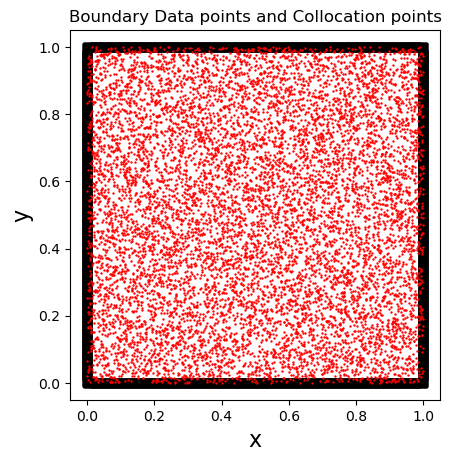

In [161]:
engine = qmc.LatinHypercube(d=1)

boundary_top = engine.random(n = N_u_boundary)
boundary_lr = engine.random(n = N_u_boundary)
boundary_bot = engine.random(n = N_u_boundary)

data = np.zeros([N_boundary, N_u_boundary, 2])

data[0, :, 0] = boundary_top[:, 0]
data[1, :, 1] = boundary_lr[:, 0]
data[2, :, 1] = boundary_lr[:, 0]
data[3, :, 0] = boundary_bot[:, 0]

data[0, :, 1] = np.ones(N_u_boundary) # y = 1
data[1, :, 0] = np.zeros(N_u_boundary) # x = 0
data[2, :, 0] = np.ones(N_u_boundary) # x = 1
data[3, :, 1] = np.zeros(N_u_boundary) # y = 0

data = data.reshape(-1, 2)
x_d, y_d = data[:, 0:1], data[:, 1:2]

engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n = N_f)

x_f, y_f = colloc[:, 0:1], colloc[:, 1:2]

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2., marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
plt.show()

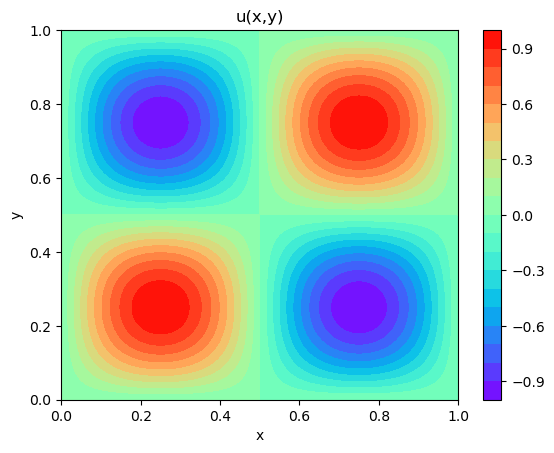

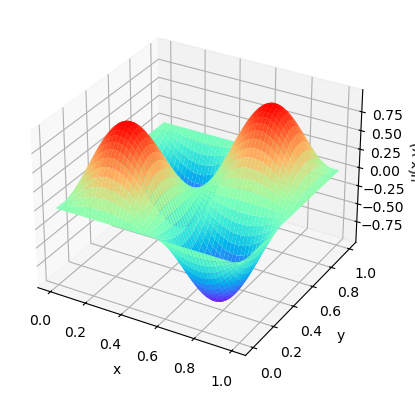

In [162]:
x = torch.linspace(x_min, x_max, total_points_x)
y = torch.linspace(y_min, y_max, total_points_y)

X, Y = torch.meshgrid(x, y)
U_real = f_real(X, Y)

plot3D_Matrix(X, Y, U_real)

In [163]:
# indexing nonsense - I don't know what this means

x_test = torch.hstack((X.transpose(1, 0).flatten()[:, None], Y.transpose(1, 0).flatten()[:, None]))
u_test = U_real.transpose(1, 0).flatten()[:, None]

x_test = x_test.float().to(device)
u_test = u_test.float().to(device)

train_bd_top = torch.tensor(boundary_top).float().to(device)
train_bd_lr = torch.tensor(boundary_lr).float().to(device)
train_bd_bot = torch.tensor(boundary_bot).float().to(device)

x_train_colloc = torch.tensor(x_f).float().to(device)
y_train_colloc = torch.tensor(y_f).float().to(device)



In [164]:
class PINN(nn.Module):

    def __init__(self, layers):
        super().__init__()
        
        #self.activation = nn.Sigmoid()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        
        self.linears = nn.ModuleList([nn.Linear (layers[i], layers[i+1]) for i in range(len(layers)-1)])
                
        # Xavier initialization
        for i in range (len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y)
        
        a = torch.cat((x.float(), y.float()), axis=1)

        
        # ugly way to make last layer linear
        for layer in self.linears[:-1]:
            z = layer(a)
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    # Neumann BC on top
    def loss_BC_top(self, x):
        x_clone = x.clone().requires_grad_(True)
        y = torch.ones_like(x_clone).requires_grad_(True)
        
        u = self.forward(x_clone, y)
        u_y = autograd.grad(u.sum(), y, create_graph=True)[0]
        
        return self.loss_function(u_y, 2 * np.pi * torch.cos(2 * np.pi * x_clone))
    
    # Periodic BC on left/right
    def loss_BC_lr(self, y):
        u_l = self.forward(torch.zeros_like(y), y)
        u_r = self.forward(torch.ones_like(y), y)
        
        return self.loss_function(u_l, u_r)
    
    # Dirichlet BC on bottom
    def loss_BC_bot(self, x):
        return self.loss_function(self.forward(x, torch.zeros_like(x)), torch.zeros_like(x))
    
    def loss_PDE(self, x, y):
        x_clone = x.clone().requires_grad_(True)
        y_clone = y.clone().requires_grad_(True)
        
        u = self.forward(x_clone, y_clone)
        u_x = autograd.grad(u.sum(), x_clone, create_graph=True)[0]
        u_y = autograd.grad(u.sum(), y_clone, create_graph=True)[0]
        u_xx = autograd.grad(u_x.sum(), x_clone, create_graph=True)[0]
        u_yy = autograd.grad(u_y.sum(), y_clone, create_graph=True)[0]

        f = u_xx + u_yy
        return self.loss_function(f + 8 * np.pi**2 * torch.sin(2 * np.pi * x_clone) * torch.sin(2 * np.pi * y_clone), torch.zeros_like(f))
    
    def loss (self, x_top, x_bot, y_lr, x_PDE, y_PDE):
        return w_bc_bottom * self.loss_BC_bot(x_bot) + w_bc_lr * self.loss_BC_lr(y_lr) + w_bc_top * self.loss_BC_top(x_top) + self.loss_PDE(x_PDE, y_PDE)

In [165]:
model = PINN(layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

In [155]:
start_time = time.time()

train_losses = np.array([])
test_losses = np.array([])

for epoch in tqdm(range(steps)):
    optimizer.zero_grad()
    loss = model.loss(train_bd_top, train_bd_bot, train_bd_lr, x_train_colloc, y_train_colloc)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        with torch.no_grad():
            # Add testing collocation points to make this work better
            test_loss = model.loss_function(model(x_test[:, 0:1], x_test[:, 1:2]), f_real(x_test[:, 0:1], x_test[:, 1:2]))
        train_losses = np.append(train_losses, loss.item())
        test_losses = np.append(test_losses, test_loss.item())
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss.item()}, Test loss {test_loss.item()}')
        
end_time = time.time()
print(f'Training time: {end_time - start_time}s')

  0%|          | 3/40000 [00:01<3:51:59,  2.87it/s] 

Epoch 0, Training loss 1590.123779296875, Test loss 0.26286911964416504


  3%|▎         | 1003/40000 [01:28<1:10:52,  9.17it/s]

Epoch 1000, Training loss 115.0149917602539, Test loss 0.8315182328224182


  5%|▌         | 2003/40000 [02:54<1:10:41,  8.96it/s]

Epoch 2000, Training loss 24.305879592895508, Test loss 0.16841542720794678


  8%|▊         | 3003/40000 [04:21<1:08:27,  9.01it/s]

Epoch 3000, Training loss 4.117121696472168, Test loss 0.09572606533765793


 10%|█         | 4002/40000 [05:50<1:12:00,  8.33it/s]

Epoch 4000, Training loss 0.5468980669975281, Test loss 0.10454939305782318


 13%|█▎        | 5002/40000 [07:18<1:10:35,  8.26it/s]

Epoch 5000, Training loss 0.21271872520446777, Test loss 0.08959513902664185


 15%|█▌        | 6002/40000 [08:45<1:09:19,  8.17it/s]

Epoch 6000, Training loss 0.1024092584848404, Test loss 0.08273659646511078


 18%|█▊        | 7002/40000 [10:12<1:06:14,  8.30it/s]

Epoch 7000, Training loss 0.056595392525196075, Test loss 0.0800686702132225


 20%|██        | 8002/40000 [11:38<1:05:06,  8.19it/s]

Epoch 8000, Training loss 0.03460187464952469, Test loss 0.07926679402589798


 23%|██▎       | 9003/40000 [13:05<56:50,  9.09it/s]  

Epoch 9000, Training loss 0.022378873080015182, Test loss 0.07917701452970505


 25%|██▌       | 10003/40000 [14:31<54:12,  9.22it/s]  

Epoch 10000, Training loss 0.015118860639631748, Test loss 0.07932409644126892


 28%|██▊       | 11003/40000 [15:57<52:30,  9.20it/s]  

Epoch 11000, Training loss 0.010947596281766891, Test loss 0.07950323075056076


 30%|███       | 12003/40000 [17:24<50:31,  9.23it/s]

Epoch 12000, Training loss 0.008309523575007915, Test loss 0.07972925156354904


 32%|███▏      | 12933/40000 [18:44<38:07, 11.83it/s]

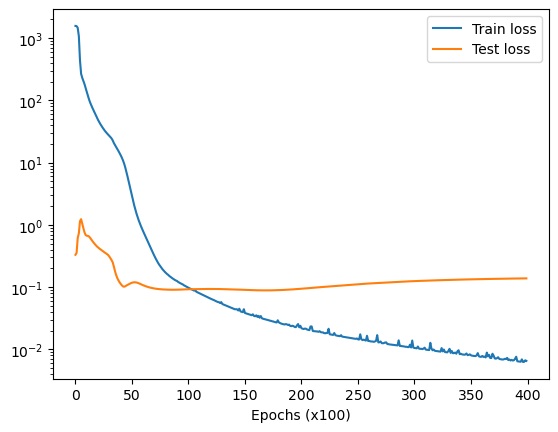

In [32]:
plt.semilogy(train_losses, label='Train loss')
plt.semilogy(test_losses, label='Test loss')
plt.xlabel('Epochs (x100)')
plt.legend()


Plots!

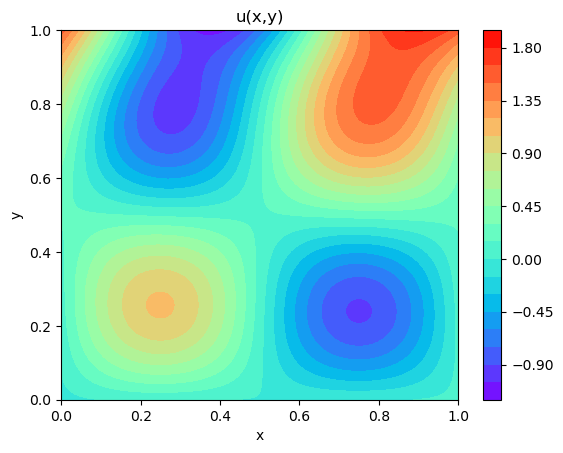

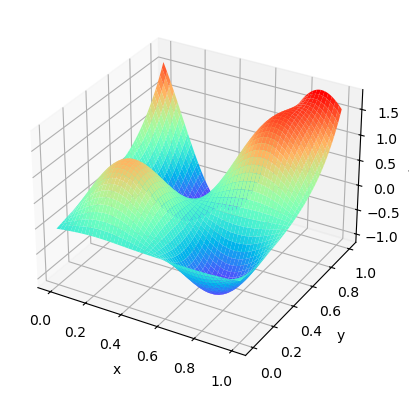

In [33]:
u_pred = model.forward(x_test[:, 0:1], x_test[:, 1:2]).cpu().detach()
u_pred = u_pred.reshape(total_points_x, total_points_y).transpose(1, 0)

# I think this transpose is correct? The shapes are weird
plot3D_Matrix(X, Y, u_pred)

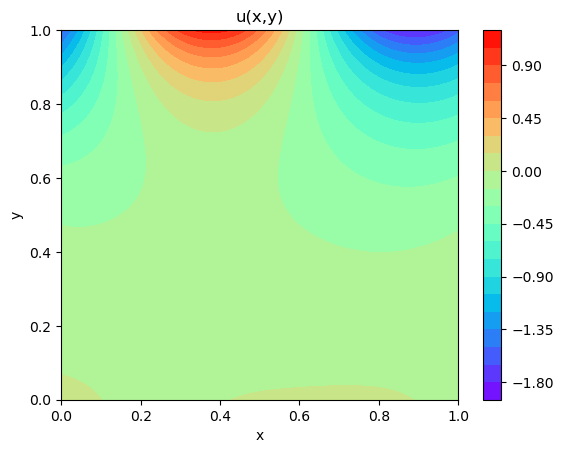

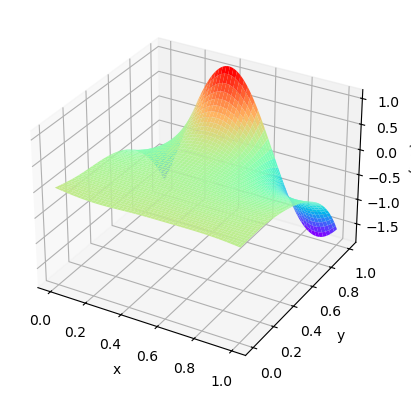

In [34]:
error = f_real(X, Y) - u_pred

plot3D_Matrix(X, Y, error)

In [35]:
x = torch.linspace(x_min, x_max, total_points_x).to(device)
y = torch.linspace(y_min, y_max, total_points_y).to(device)

X, Y = np.meshgrid(x.cpu(), y.cpu())

S = model.forward(torch.tensor(X.flatten()[:, None]).to(device), torch.tensor(Y.flatten()[:, None]).to(device))

[0, 49, 99, 149, 199]


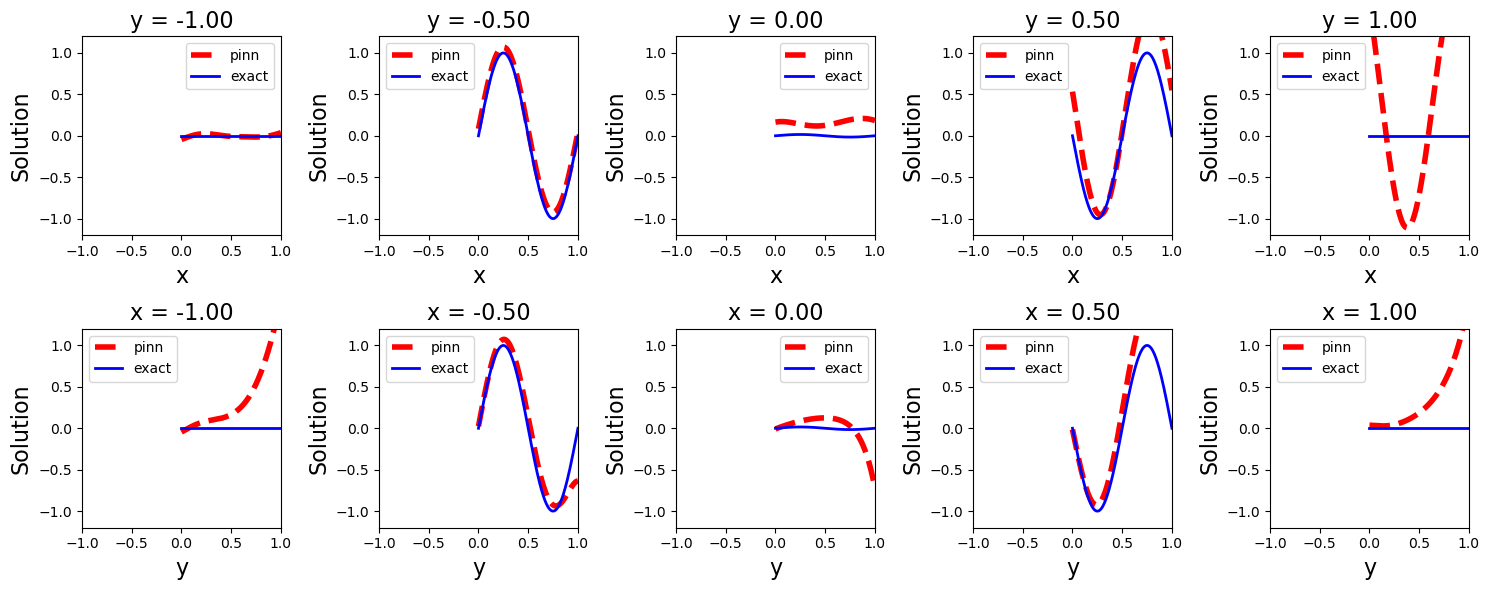

In [37]:
S_ = S.reshape(total_points_x, total_points_y)
T_ = np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y)

height = 3
frames_val = np.array([-1., -0.5, 0., 0.5, 1.])
frames = [*map(int, (frames_val + 1)/2 * (200-1))]
fig = plt.figure("", figsize=(len(frames)*height, 2*height))

print(frames)

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"y = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X[var_index, :], S_[var_index,:].cpu().detach().numpy(), "r--", lw=4., label="pinn")
    plt.plot(X[var_index, :], T_[var_index,:], "b", lw=2., label="exact")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1., +1.)
    plt.xlabel("x",fontsize=16)
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"x = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(Y[:, var_index], S_[:,var_index].cpu().detach().numpy(), "r--", lw=4., label="pinn")
    plt.plot(Y[:, var_index], T_[:,var_index], "b", lw=2., label="exact")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1., +1.)
    plt.xlabel("y",fontsize=16)
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

#plt.savefig("profiles.png")
plt.show()